In [1]:
import numpy as np
from scipy.stats import rankdata
from sklearn.metrics import ndcg_score
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn import svm
from ranking_svm import RankSVM, transform_pairwise

import matplotlib
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rc('xtick', labelsize=15)
import matplotlib.pyplot as plt

# Global parameters

In [2]:
ntr = 300
n = 500
m = 500

alpha = .1 # coverage level
beta = .2 # P(FCP<a)> 1-b  (FCP control)
delta = .02

# Quantile Envelope

In [3]:
from scipy.optimize import minimize_scalar

# Find gamma for the quantile envelope
def find_gamma(gamma, sample_R, delta=0.02):
    K = len(sample_R)
    if gamma < 0:
        ai = np.quantile(sample_R, 0, axis=0)
        bi = np.quantile(sample_R, 1, axis=0)
    elif gamma > 1:
        ai = np.quantile(sample_R, 1, axis=0)
        bi = np.quantile(sample_R, 0, axis=0)
    else:
        ai = np.quantile(sample_R, gamma, axis=0)
        bi = np.quantile(sample_R, 1-gamma, axis=0)

    E = 0
    for i in range(K):
        E += (np.sum((sample_R[i]>=ai)*(sample_R[i]<=bi)) >= n)*1
    E /= K
        
    return abs(E-(1-delta))

# Find c for the quantile envelope
def find_c(c, sample_R, delta=0.02):
    K = len(sample_R)
    ai = np.arange(1, n+1)/n - c
    bi = np.arange(1, n+1)/n + c

    E = 0
    for i in range(K):
        E += (np.sum((sample_R[i]>=ai)*(sample_R[i]<=bi))==n)*1
    E /= K
        
    return abs(E-(1-delta))

In [4]:
# Simulation of R^{c+t} and estimation of the law 
# of the pvalue to control the FCP on the test

K = 10000
sample_R = []
Pvalues = []
for _ in range(K):
    Un = np.random.normal(0, 1, size=n)
    Um = np.random.normal(0, 1, size=m)
    Fm = ECDF(Um)
    Fc = ECDF(Un)
    
    # Simulation of the vector R^{c+t} (Algorithm 1)
    ind = np.argsort(Un)
    sample_R.append(Fm(Un[ind]))
    
    # Simulation of the vector of conformal pvalues
    p = (n*Fc(Um) + 1)/(n+1)
    Pvalues.append(np.sort(p))
    
sample_R = np.array(sample_R)
Pvalues = np.array(Pvalues)

In [5]:
quantile_envelope = True
if quantile_envelope:
    res = minimize_scalar(find_gamma, args=(sample_R, delta), method='Golden')
    gamma = res.x*1
    Ri_low = np.quantile(sample_R, gamma, axis=0)
    Ri_high = np.quantile(sample_R, 1-gamma, axis=0)
else:
    res = minimize_scalar(find_c, args=(sample_R, delta), method='Golden')
    c = res.x*1
    Ri_low = np.arange(1, n+1)/n - c
    Ri_high = np.arange(1, n+1)/n + c

In [6]:
E = []
for i in range(K):
    E.append( (np.sum((sample_R[i]>=Ri_low)*(sample_R[i]<=Ri_high)) >= n)*1 )
delta_optim = 1-np.mean(E)

print('Probabilty to be in the envelope:', 1-delta_optim)

Probabilty to be in the envelope: 0.9807


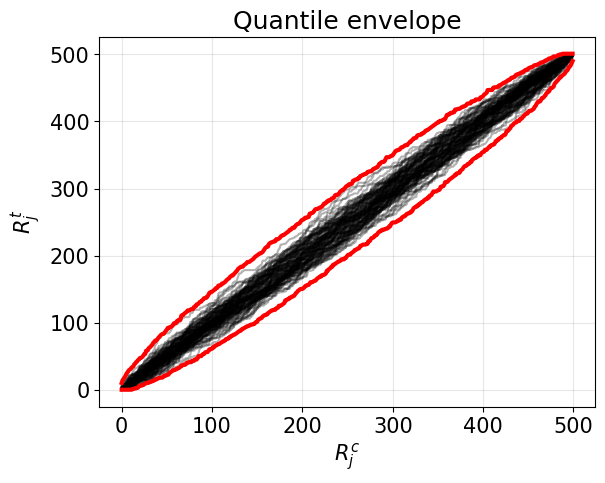

In [7]:
plt.plot(sample_R[:100].T*(m+1), color='k', alpha=.3);
plt.plot(Ri_low*(m+1), color='r', lw=3);
plt.plot(Ri_high*(m+1), color='r', lw=3);
plt.title('Quantile envelope')
plt.xlabel('$R^{c}_j$')
plt.ylabel('$R^{t}_j$')
plt.grid(alpha=.3);

# Generation of the data set

In [8]:
np.random.seed(2)

n_samples, n_features = ntr + n + m, 5

dataset = 1
if dataset==1:
    true_coef = np.random.randn(n_features)
    X = np.random.randn(n_samples, n_features)
    noise = np.random.normal(0, .07, size=n_samples)
    y = 1/(1 + np.exp(-np.dot(X, true_coef))) + noise
else:
    true_coef = 1
    noise = np.random.normal(0, .07, size=n_samples)
    X = np.random.beta(.04, .04, size=n_samples).reshape((-1, 1))
    y = 2*np.dot(X[:, 0], true_coef) + noise

total = np.arange(n_samples)
train, calib, test = total[:ntr], total[ntr:ntr+n], total[ntr+n:]
calib_test = np.concatenate((calib, test))

R_calib = rankdata(y[calib])

R_calib_test = rankdata(y[calib_test]) # unknown
R_test = rankdata(y[calib_test])[n:] # unknown

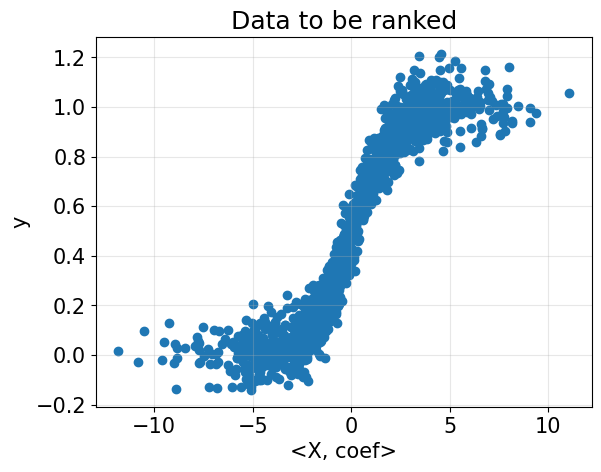

In [9]:
# make a simple plot out of it
plt.scatter(np.dot(X, true_coef), y)
plt.title('Data to be ranked')
plt.xlabel('<X, coef>')
plt.ylabel('y')
plt.grid(alpha=.3);

# Training of the RankSVM

In [64]:
# print the performance of ranking
clf = svm.LinearSVC(C=.1, max_iter= 10)
rank_svm = RankSVM(clf).fit(X[train], y[train])

print( np.mean(abs(rank_svm.predict_score(X[test]) - y[test])) )
# print('NDCG', ndcg_score([y[test]], [rank_svm.predict_score(X[test])]))

0.7365794092500976


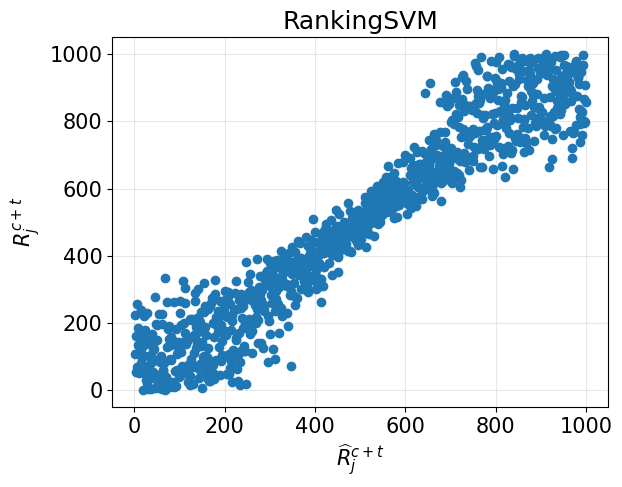

In [65]:
# Result of the ranking on calib + test
plt.plot(rankdata(rank_svm.predict_score(X[calib_test])), R_calib_test, 'o')
plt.title('RankingSVM')
plt.xlabel('$\\widehat{R}^{c+t}_j$')
plt.ylabel('$R^{c+t}_j$')
plt.grid(alpha=.3);

# Calibration with TCPR method

In [66]:
beta_adjust = beta - delta_optim
            
# Control of the FCP
l = int(np.floor( alpha*m ) + 1)
alpha_FCP = np.quantile(Pvalues[:, l-1], beta_adjust)

if np.mean(Pvalues[:, l-1] > alpha_FCP) < 1-beta:
    e = []
    prange = np.linspace(0, 1, 10000)
    for t in prange:
        e.append(np.mean(Pvalues[:, l-1] > t))
    e = np.array(e)
    ind = np.sum(np.array(e) > 1-beta_adjust)-1
    alpha_FCP = prange[ind]

k = int(np.ceil((n+1)*(1-alpha_FCP)))
print(alpha_FCP, k)

0.08582834331337326 458


In [67]:
# Ranking part
tie_breaker = np.random.uniform(0.00001, size=len(y))
y_pred_calib = rank_svm.predict_score(X[calib]) + tie_breaker[calib]
y_pred_test = rank_svm.predict_score(X[test]) + tie_breaker[test]
y_pred_calib_test = rank_svm.predict_score(X[calib_test]) + tie_breaker[calib_test]

R_pred_calib_test = rankdata(y_pred_calib_test)
R_pred_test = R_pred_calib_test[n:]

In [68]:
Fy_c = ECDF(y[calib])
Fy_t = ECDF(y[test])

Fx_c = ECDF(y_pred_calib)
Fx_t = ECDF(y_pred_test)

Rx_c = np.array(Fx_c(y_pred_calib)*n, dtype=int)
Rx_t = np.array(Fx_t(y_pred_calib)*m, dtype=int)

Ry_c = np.array(Fy_c(y[calib])*n, dtype=int)
Ry_t = np.array(Fy_t(y[calib])*m, dtype=int)

## Bounds on $R^{t}_j$

In [69]:
r_low = Ri_low[Ry_c-1]*(m+1)
r_high = Ri_high[Ry_c-1]*(m+1)

## (RA) setting 

In [70]:
score_bound_low = np.abs( (Rx_c + Rx_t) - (Ry_c + r_low))
score_bound_high = np.abs( (Rx_c + Rx_t) - (Ry_c + r_high))
score_proxy_RA = np.fmax(score_bound_low, score_bound_high)
q_RA = np.sort(score_proxy_RA)[k-1]

C_RA_low = np.fmax(1, R_pred_test - q_RA)
C_RA_high = np.fmin(R_pred_test + q_RA, n+m)

FCP_t_RA = 1-np.mean( ((R_test <= R_pred_test + q_RA)*(R_test >= R_pred_test - q_RA)))
relative_length_RA = np.mean(C_RA_high-C_RA_low)/(n+m)
print('FCP_t (RA):', FCP_t_RA)
print('relative length (RA):', relative_length_RA)

FCP_t (RA): 0.030000000000000027
relative length (RA): 0.40678289600000006


## (VA) setting

In [71]:
a = np.array(np.fmax(1, np.floor(Ry_c + r_low)), dtype=int)
b = np.array(np.fmin(n+m, np.ceil(Ry_c + r_high)), dtype=int)

value_to_index = {val: idx for idx, val in enumerate(R_pred_calib_test)}
ind_a = np.array([value_to_index[x] for x in a])
ind_b = np.array([value_to_index[x] for x in b])

score_bound_low = np.array(abs(y_pred_calib_test[ind_a] - y_pred_calib_test[:n]))
score_bound_high = np.array(abs(y_pred_calib_test[ind_b] - y_pred_calib_test[:n]))
score_proxy_VA = np.fmax(score_bound_low, score_bound_high)
q_VA = np.sort(score_proxy_VA)[k-1]

C_VA_low = np.zeros(n+m)
C_VA_high = np.zeros(n+m)
for i in range(n+m):
    C_VA_low[i] = np.sum(y_pred_calib_test < (y_pred_calib_test[i] - q_VA))
    C_VA_high[i] = np.sum(y_pred_calib_test < (y_pred_calib_test[i] + q_VA))
    
FCP_t_VA = 1-np.mean( ((R_test >= C_VA_low[n:])*(R_test <= C_VA_high[n:])) )
relative_length_VA = np.mean(np.abs(C_VA_low-C_VA_high))/(n+m)
print('FCP_t (VA):', FCP_t_VA)
print('relative length (VA):', relative_length_VA)

FCP_t (VA): 0.06399999999999995
relative length (VA): 0.5669270000000001


## Visualisation

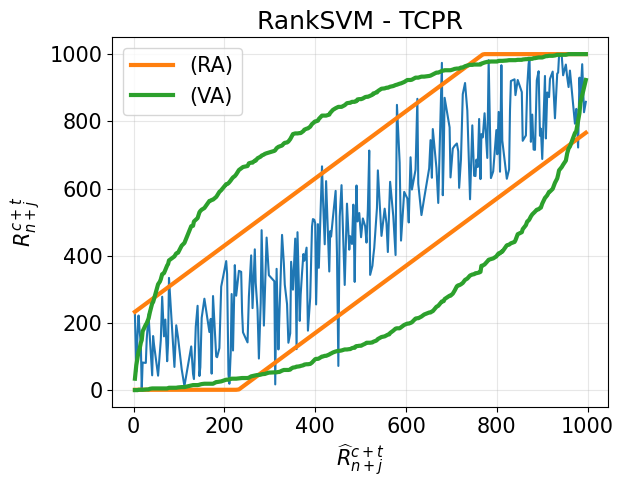

In [72]:
ind = np.argsort(R_pred_test)

c = 2
plt.plot(R_pred_test[ind][::c], R_test[ind][::c], '-')
plt.plot(R_pred_test[ind][::c], C_RA_low[ind][::c], '-', color='C1', lw=3, label='(RA)')
plt.plot(R_pred_test[ind][::c], C_RA_high[ind][::c], '-', color='C1', lw=3)
plt.plot(R_pred_test[ind][::c], C_VA_low[n:][ind][::c], '-', color='C2', lw=3, label='(VA)')
plt.plot(R_pred_test[ind][::c], C_VA_high[n:][ind][::c], '-', color='C2', lw=3)

plt.grid(alpha=.3)
plt.xlabel('$\\widehat{R}^{c+t}_{n+j}$')
plt.ylabel('$R^{c+t}_{n+j}$')
plt.title('RankSVM - TCPR')
plt.legend();

# Oracle method

In [73]:
# Control of the FCP
l = int(np.floor( alpha*m ) + 1)
alpha_FCP = np.quantile(Pvalues[:, l-1], beta)

if np.mean(Pvalues[:, l-1] > alpha_FCP) < 1-beta:
    e = []
    prange = np.linspace(0, 1, 10000)
    for t in prange:
        e.append(np.mean(Pvalues[:, l-1] > t))
    e = np.array(e)
    ind = np.sum(np.array(e) > 1-beta)-1
    alpha_FCP = prange[ind]

k_Oracle = int(np.ceil((n+1)*(1-alpha_FCP)))
print(alpha_FCP, k_Oracle)

0.08780878087808781 458


In [74]:
score_proxy_RA_Oracle = np.abs( (Rx_c + Rx_t) - (Ry_c + Ry_t))
q_RA_Oracle = np.sort(score_proxy_RA_Oracle)[k_Oracle-1]

C_RA_Oracle_low = np.fmax(1, R_pred_test - q_RA_Oracle)
C_RA_Oracle_high = np.fmin(R_pred_test + q_RA_Oracle, n+m)

FCP_t_RA_Oracle = 1-np.mean( ((R_test <= R_pred_test + q_RA_Oracle)*(R_test >= R_pred_test - q_RA_Oracle)))
relative_length_RA_Oracle = np.mean(C_RA_Oracle_high-C_RA_Oracle_low)/(n+m)
print('FCP_t Oracle (RA):', FCP_t_RA_Oracle)
print('relative length Oracle (RA):', relative_length_RA_Oracle)

FCP_t Oracle (RA): 0.08999999999999997
relative length Oracle (RA): 0.33829000000000004


In [75]:
value_to_index = {val: idx for idx, val in enumerate(R_pred_calib_test)}
ind_s = np.array([value_to_index[x] for x in (Ry_c + Ry_t)])
score_proxy_VA_Oracle = np.array(abs(y_pred_calib_test[ind_s] - y_pred_calib_test[:n]))
q_VA_Oracle = np.sort(score_proxy_VA_Oracle)[k_Oracle-1]

C_VA_Oracle_low = np.zeros(n+m)
C_VA_Oracle_high = np.zeros(n+m)
for i in range(n+m):
    C_VA_Oracle_low[i] = np.sum(y_pred_calib_test < (y_pred_calib_test[i] - q_VA_Oracle))
    C_VA_Oracle_high[i] = np.sum(y_pred_calib_test < (y_pred_calib_test[i] + q_VA_Oracle))
    
FCP_t_VA_Oracle = 1-np.mean( ((R_test >= C_VA_Oracle_low[n:])*(R_test <= C_VA_Oracle_high[n:])) )
relative_length_VA_Oracle = np.mean(np.abs(C_VA_Oracle_low-C_VA_Oracle_high))/(n+m)
print('FCP_t Oracle (VA):', FCP_t_VA_Oracle)
print('relative length Oracle (VA):', relative_length_VA_Oracle)

FCP_t Oracle (VA): 0.10199999999999998
relative length Oracle (VA): 0.483321


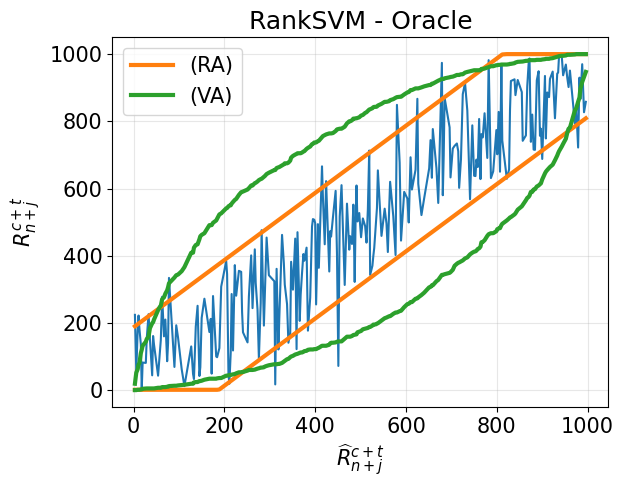

In [76]:
ind = np.argsort(R_pred_test)

c = 2
plt.plot(R_pred_test[ind][::c], R_test[ind][::c], '-')
plt.plot(R_pred_test[ind][::c], C_RA_Oracle_low[ind][::c], '-', color='C1', lw=3, label='(RA)')
plt.plot(R_pred_test[ind][::c], C_RA_Oracle_high[ind][::c], '-', color='C1', lw=3)
plt.plot(R_pred_test[ind][::c], C_VA_Oracle_low[n:][ind][::c], '-', color='C2', lw=3, label='(VA)')
plt.plot(R_pred_test[ind][::c], C_VA_Oracle_high[n:][ind][::c], '-', color='C2', lw=3)

plt.grid(alpha=.3)
plt.xlabel('$\\widehat{R}^{c+t}_{n+j}$')
plt.ylabel('$R^{c+t}_{n+j}$')
plt.title('RankSVM - Oracle')
plt.legend();

# Comparison TCPR and Oracle

In [77]:
print('FCP_t (RA):', FCP_t_RA, 'relative length (RA):', relative_length_RA)
print('FCP_t (VA):', FCP_t_VA, 'relative length (VA):', relative_length_VA)
print('FCP_t Oracle (RA):', FCP_t_RA_Oracle, 'relative length Oracle (RA):', relative_length_RA_Oracle)
print('FCP_t Oracle (VA):', FCP_t_VA_Oracle, 'relative length Oracle (VA):', relative_length_VA_Oracle)

FCP_t (RA): 0.030000000000000027 relative length (RA): 0.40678289600000006
FCP_t (VA): 0.06399999999999995 relative length (VA): 0.5669270000000001
FCP_t Oracle (RA): 0.08999999999999997 relative length Oracle (RA): 0.33829000000000004
FCP_t Oracle (VA): 0.10199999999999998 relative length Oracle (VA): 0.483321


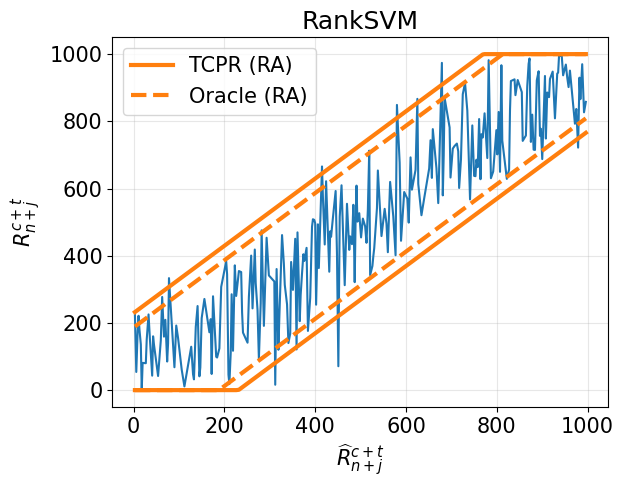

In [78]:
ind = np.argsort(R_pred_test)

c = 2
plt.plot(R_pred_test[ind][::c], R_test[ind][::c], '-')
plt.plot(R_pred_test[ind][::c], C_RA_low[ind][::c], '-', color='C1', lw=3, label='TCPR (RA)')
plt.plot(R_pred_test[ind][::c], C_RA_high[ind][::c], '-', color='C1', lw=3)

plt.plot(R_pred_test[ind][::c], C_RA_Oracle_low[ind][::c], '--', color='C1', lw=3, label='Oracle (RA)')
plt.plot(R_pred_test[ind][::c], C_RA_Oracle_high[ind][::c], '--', color='C1', lw=3)

plt.grid(alpha=.3)
plt.xlabel('$\\widehat{R}^{c+t}_{n+j}$')
plt.ylabel('$R^{c+t}_{n+j}$')
plt.title('RankSVM')
plt.legend();
# plt.savefig('TCPR_example_RA.pdf', bbox_inches='tight')

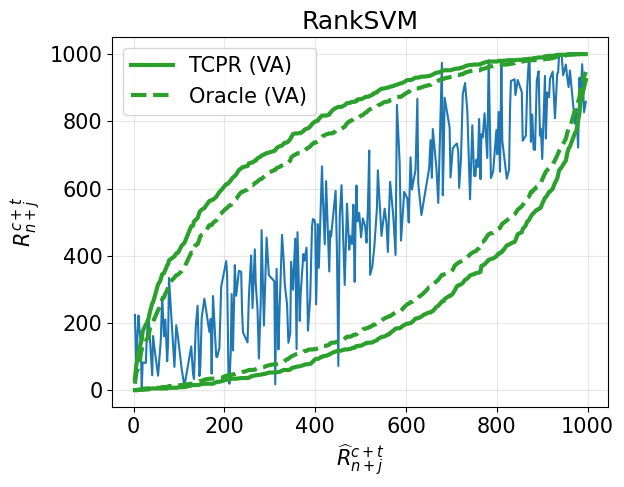

In [79]:
ind = np.argsort(R_pred_test)

c = 2
plt.plot(R_pred_test[ind][::c], R_test[ind][::c], '-')
plt.plot(R_pred_test[ind][::c], C_VA_low[n:][ind][::c], '-', color='C2', lw=3, label='TCPR (VA)')
plt.plot(R_pred_test[ind][::c], C_VA_high[n:][ind][::c], '-', color='C2', lw=3)

plt.plot(R_pred_test[ind][::c], C_VA_Oracle_low[n:][ind][::c], '--', color='C2', lw=3, label='Oracle (VA)')
plt.plot(R_pred_test[ind][::c], C_VA_Oracle_high[n:][ind][::c], '--', color='C2', lw=3)

plt.grid(alpha=.3)
plt.xlabel('$\\widehat{R}^{c+t}_{n+j}$')
plt.ylabel('$R^{c+t}_{n+j}$')
plt.title('RankSVM')
plt.legend();
# plt.savefig('TCPR_example_VA.pdf', bbox_inches='tight')